<a href="https://colab.research.google.com/github/Sahil-Rajarai/recommender-systems/blob/master/RecSys_coursework_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assessed Coursework Template Notebook

This is the template notebook for the RecSys(H) 2020 coursework. It deals with data preparation and evaluation only.

Please note:
 - use H1 text headings for grouping together blocks of cells. You can then hide these while working on other blocks
 - leave the cell output visible when you submit the notebook



## Setup block

Setup the data files, Python etc.

In [0]:
!rm -rf ratings* books* to_read* test*

!curl -o ratings.csv "http://www.dcs.gla.ac.uk/~craigm/recsysH/coursework/final-ratings.csv" 
!curl -o books.csv "http://www.dcs.gla.ac.uk/~craigm/recsysH/coursework/final-books.csv"
!curl -o to_read.csv "http://www.dcs.gla.ac.uk/~craigm/recsysH/coursework/final-to_read.csv"
!curl -o test.csv "http://www.dcs.gla.ac.uk/~craigm/recsysH/coursework/final-test.csv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7631k  100 7631k    0     0  3592k      0  0:00:02  0:00:02 --:--:-- 3591k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2366k  100 2366k    0     0  1526k      0  0:00:01  0:00:01 --:--:-- 1525k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7581k  100 7581k    0     0  4140k      0  0:00:01  0:00:01 --:--:-- 4138k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1895k  100 1895k    0     0  1199k      0  0:00:01  0:00:01 --:--:-- 1199k


In [0]:
#Standard setup
import pandas as pd
import numpy as np
import torch
!pip install git+https://github.com/cmacdonald/spotlight.git@master#egg=spotlight
from spotlight.interactions import Interactions


# data preparation

In [0]:
#load in the csv files
ratings_df = pd.read_csv("ratings.csv")
books_df = pd.read_csv("books.csv")
to_read_df = pd.read_csv("to_read.csv")
test = pd.read_csv("test.csv")

In [0]:
#cut down the number of items and users
counts=ratings_df[ratings_df["book_id"] < 2000].groupby(["book_id"]).count().reset_index()
valid_books=counts[counts["user_id"] >= 10][["book_id"]]

books_df = books_df.merge(valid_books, on="book_id")

ratings_df = ratings_df[ratings_df["user_id"] < 2000].merge(valid_books, on="book_id")
to_read_df = to_read_df[to_read_df["user_id"] < 2000].merge(valid_books, on="book_id")
test = test[test["user_id"] < 2000].merge(valid_books, on="book_id")


Here we construct the Interactions objects from `ratings.csv`, `to_read.csv` and `test.csv`. We manually specify the num_users and num_items parameters to all Interaction objects, in case the test set differs from your training sets.

In [0]:
from collections import defaultdict
from itertools import count

from spotlight.cross_validation import random_train_test_split

iid_map = defaultdict(count().__next__)


rating_iids = np.array([iid_map[iid] for iid in ratings_df["book_id"].values], dtype = np.int32)
test_iids = np.array([iid_map[iid] for iid in test["book_id"].values], dtype = np.int32)
toread_iids = np.array([iid_map[iid] for iid in to_read_df["book_id"].values], dtype = np.int32)


uid_map = defaultdict(count().__next__)
test_uids = np.array([uid_map[uid] for uid in test["user_id"].values], dtype = np.int32)
rating_uids = np.array([uid_map[uid] for uid in ratings_df["user_id"].values], dtype = np.int32)
toread_uids = np.array([uid_map[iid] for iid in to_read_df["user_id"].values], dtype = np.int32)


uid_rev_map = {v: k for k, v in uid_map.items()}
iid_rev_map = {v: k for k, v in iid_map.items()}


rating_dataset = Interactions(user_ids=rating_uids,
                               item_ids=rating_iids,
                               ratings=ratings_df["rating"].values,
                               num_users=len(uid_rev_map),
                               num_items=len(iid_rev_map))

toread_dataset = Interactions(user_ids=toread_uids,
                               item_ids=toread_iids,
                               num_users=len(uid_rev_map),
                               num_items=len(iid_rev_map))

test_dataset = Interactions(user_ids=test_uids,
                               item_ids=test_iids,
                               num_users=len(uid_rev_map),
                               num_items=len(iid_rev_map))

print(rating_dataset)
print(toread_dataset)
print(test_dataset)

#here we define the validation set
# toread_dataset_train, validation = random_train_test_split(toread_dataset, random_state=np.random.seed(42))
toread_dataset_train, validation = random_train_test_split(toread_dataset, random_state=np.random.RandomState(42))


num_items = test_dataset.num_items
num_users = test_dataset.num_users

<Interactions dataset (1999 users x 1826 items x 124762 interactions)>
<Interactions dataset (1999 users x 1826 items x 135615 interactions)>
<Interactions dataset (1999 users x 1826 items x 33917 interactions)>


#Example code

To evaluate soem of your hand-implemented recommender systems (e.g. Q1, Q4), you will need to instantiate objects that match the specification of a Spotlight model, which `mrr_score()` expects.


Here is an example recommender object that returns 0 for each item, regardless of user.

In [0]:
from spotlight.evaluation import mrr_score


class dummymodel:
  
  def __init__(self, numitems):
    self.predictions=np.zeros(numitems)
  
  #uid is the user we are requesting recommendations for;
  #returns an array of scores, one for each item
  def predict(self, uid):
    #this model returns all zeros, regardless of userid
    return( self.predictions )

#lets evaluate how the effeciveness of dummymodel

print(mrr_score(dummymodel(num_items), test_dataset, train=rating_dataset, k=100).mean())
#as expected, a recommendation model that gives 0 scores for all items obtains a MRR score of 0



0.0


In [0]:

#note that the latest copy of Craig's Spotlight displays a progress bar if you set verbose=True
print(mrr_score(dummymodel(num_items), test_dataset, train=rating_dataset, k=100, verbose=True).mean())


1999it [00:00, 2942.56it/s]

0.0


#Q1

You should create one block for each question

In [0]:
#Average rating, obtained from ratings.csv
#use sort=false so as to get the book id instead of 0,1,2...

class averageRating:
  def __init__(self, numitems):
      self.predictions = np.array(ratings_df.groupby(["book_id"], sort=False).mean()['rating'])

  def predict(self, uid):
    return( self.predictions )

#calculate mmr score
print(mrr_score(averageRating(num_items), test_dataset, train=rating_dataset, k=100).mean())

0.015052024168984034


In [0]:
#construct a dictionary to put the actual book id and their rating counts
rating_counts = np.array(books_df['ratings_count'])
book_id = np.array(books_df['book_id'])
book_rating = np.zeros(num_items)
for i in range (len(book_id)) :
  curr_id = iid_map.get(book_id[i])
  book_rating[curr_id] = rating_counts[i]

In [0]:
#Number of ratings, obtained from books.csv (column ratings_count)
class numRatings :

  def __init__(self, numitems):       
      self.predictions = book_rating

  def predict(self, uid):
    return( self.predictions )

#calculate mmr score
print(mrr_score(numRatings(num_items), test_dataset, train=rating_dataset, k=100).mean())


0.2396001188245477


In [0]:
 #construct a dictionary to put the actual book id and their Number of 5* ratings
rating_5 = np.array(books_df['ratings_5'])
book_id = np.array(books_df['book_id'])
book_rating_5 = np.zeros(num_items)
for i in range (len(book_id)) :
  curr_id = iid_map.get(book_id[i])
  book_rating_5[curr_id] = rating_5[i]

In [0]:
#Number of 5* ratings, obtained from books.csv

class numFiveStars :

  def __init__(self):
      self.predictions = book_rating_5

  def predict(self, uid):
    return( self.predictions )

#calculate mmr score
print(mrr_score(numFiveStars(), test_dataset, train=rating_dataset, k=100).mean())

0.2409670879930144


In [0]:
#Fraction of 5* ratings, calculated from the two evidence above

class fractionFiveStars :
  
  def __init__(self):
      self.predictions = book_rating_5/book_rating

  def predict(self, uid):
    return( self.predictions )

print(mrr_score(fractionFiveStars(), test_dataset, train=rating_dataset, k=100).mean())

0.03415267465103555


#Q2


In [0]:
from spotlight.factorization.explicit import ExplicitFactorizationModel
from spotlight.factorization.implicit import ImplicitFactorizationModel

#ExplicitFactorizationModel
latent_factors = [8, 16, 32, 64]
best_score_explicit = 0
best_model_Explicit = 0
best_latent_factor_explicit = 0

#loop through latent_factors and use the validation set to find the maximise MRR
for i in latent_factors :
  print('Latent factor ', str(i))
  emodel = ExplicitFactorizationModel(n_iter=5, random_state=np.random.RandomState(1), embedding_dim=i, use_cuda=False)              
  emodel.fit(rating_dataset, verbose=True)
  score = mrr_score(emodel, validation, train=rating_dataset, k=100).mean()
  if score >= best_score_explicit :
    best_score_explicit = score
    best_latent_factor_explicit = i
    best_model_Explicit = emodel

#Evaluate the best model in terms of MRR using the provided test data
print('best latent factor for ExplicitFactorizationModel is ', best_latent_factor_explicit)
print('best model in terms of MRR ',  mrr_score(best_model_Explicit, test_dataset, train=rating_dataset, k=100).mean())

Latent factor  8
Epoch 0: loss 5.546910882484718
Epoch 1: loss 0.8069540473525642
Epoch 2: loss 0.7444186094598692
Epoch 3: loss 0.7016327472739532
Epoch 4: loss 0.6687415688008559
Latent factor  16
Epoch 0: loss 4.50729059134839
Epoch 1: loss 0.7876759265534213
Epoch 2: loss 0.6983933953232453
Epoch 3: loss 0.63182490025876
Epoch 4: loss 0.5818731948489049
Latent factor  32
Epoch 0: loss 3.9730885583357733
Epoch 1: loss 0.7902639296944024
Epoch 2: loss 0.6297312552323107
Epoch 3: loss 0.5185502647865013
Epoch 4: loss 0.446325780854362
Latent factor  64
Epoch 0: loss 3.4746042099155363
Epoch 1: loss 0.7811282048704195
Epoch 2: loss 0.5363745120216589
Epoch 3: loss 0.41745556347438545
Epoch 4: loss 0.3746082321664349
best latent factor for ExplicitFactorizationModel is  32
best model in terms of MRR  0.05502920579265286


In [0]:
#ImplicitFactorizationModel
best_score_implicit = 0
best_model_implicit = 0
best_latent_factor_implicit = 0

#loop through latent_factors and use the validation set to find the maximise MRR
for i in latent_factors :
  print('Latent factor ', str(i))
  imodel = ImplicitFactorizationModel(n_iter=5,random_state=np.random.RandomState(1),embedding_dim=i,loss='bpr',use_cuda=False)
  imodel.fit(rating_dataset, verbose=True)
  score = mrr_score(imodel, validation, train=rating_dataset, k=100).mean()
  if(score > best_score_implicit) :
    best_score_implicit = score
    best_latent_factor_implicit = i
    best_model_implicit = imodel

#Evaluate the best model in terms of MRR using the provided test data
print('best latent factor for ImplicitFactorizationModel is ', best_latent_factor_implicit)
print('best model in terms of MRR ',  mrr_score(best_model_implicit, test_dataset, train=rating_dataset, k=100).mean())

Latent factor  8
Epoch 0: loss 0.3800143991581729
Epoch 1: loss 0.226812304043379
Epoch 2: loss 0.1765885273086243
Epoch 3: loss 0.15752846656031297
Epoch 4: loss 0.14882757948314557
Latent factor  16
Epoch 0: loss 0.3444690479301527
Epoch 1: loss 0.19967963949578707
Epoch 2: loss 0.16321104065683045
Epoch 3: loss 0.1465598158996369
Epoch 4: loss 0.1378573360929235
Latent factor  32
Epoch 0: loss 0.32365596205851094
Epoch 1: loss 0.1852227891260972
Epoch 2: loss 0.15285226719484465
Epoch 3: loss 0.13484459292510007
Epoch 4: loss 0.12610292912567736
Latent factor  64
Epoch 0: loss 0.3059170442160036
Epoch 1: loss 0.16935962159186602
Epoch 2: loss 0.13890057457152938
Epoch 3: loss 0.12148511840305368
Epoch 4: loss 0.11332039408324683
best latent factor for ImplicitFactorizationModel is  16
best model in terms of MRR  0.3887596323416617


In [0]:
#store the best model
best_model_Q2 = best_model_implicit

#Q3

In [0]:
#ImplicitFactorizationModel on the implicit training data
scoreQ3 = 0
best_model_Q3 = 0
best_latent_factor_Q3 = 0

for i in latent_factors :
  print('Latent factor ', str(i))
  imodel = ImplicitFactorizationModel(n_iter=5,embedding_dim=i,random_state=np.random.RandomState(1),loss='bpr',use_cuda=False)
  imodel.fit(toread_dataset_train, verbose=True)
  score = mrr_score(imodel, validation, train=toread_dataset_train, k=100).mean()
  if score > scoreQ3 :
    scoreQ3 = score
    best_latent_factor_Q3 = i
    best_model_Q3 = imodel

# Evaluate the final model in terms of MRR using the provided test data
print('Best model in terms of MRR ',  mrr_score(best_model_Q3, test_dataset, train=rating_dataset, k=100).mean())

Latent factor  8
Epoch 0: loss 0.39337800112816523
Epoch 1: loss 0.24179184918274294
Epoch 2: loss 0.19207951633857107
Epoch 3: loss 0.17463349203034392
Epoch 4: loss 0.16280447224260503
Latent factor  16
Epoch 0: loss 0.35834955793084966
Epoch 1: loss 0.2094157070694667
Epoch 2: loss 0.17453473395193522
Epoch 3: loss 0.15932149856509464
Epoch 4: loss 0.14717754435215918
Latent factor  32
Epoch 0: loss 0.3424184679774181
Epoch 1: loss 0.19521144282002495
Epoch 2: loss 0.16036324589601103
Epoch 3: loss 0.14363892933459216
Epoch 4: loss 0.1304559223529584
Latent factor  64
Epoch 0: loss 0.32598371304712204
Epoch 1: loss 0.18099869759577625
Epoch 2: loss 0.14648431298797424
Epoch 3: loss 0.1284485306098776
Epoch 4: loss 0.11467573814586086
Best model in terms of MRR  0.39064620076019624


In [0]:
import scipy.stats as st
# userids for which the system attained the highest RR score
def countRatings(uid, rr):
  print("User with id %d with highest RR %f" %( uid, rr))

rrs = mrr_score(best_model_Q3, test_dataset, train=rating_dataset, k=100)
RR_ranks = st.rankdata(-rrs, method='min')
countRatings( np.argwhere(RR_ranks==1).item(0), rrs[RR_ranks==1].item(0) )
x = st.rankdata(-best_model_Q3.predict(np.argwhere(RR_ranks==1).item(0)),method='min')
bookIdlst = []
#get the top five books
top_five = [a.item(0) for a in np.argwhere(x<=5)]
print(top_five)

for i in range(len(top_five)) :
  #get the book id and the title
  bookId = iid_rev_map[top_five[i]]
  bookIdlst.append(bookId)
  print(books_df[books_df.book_id == bookId]['title'])

# y = iid_rev_map[24]
# print('sas', y)
# print('sas', books_df[(books_df['book_id'] == y)]['title'])

User with id 1 with highest RR 1.000000
[21, 23, 24, 34, 52]
4    The Great Gatsby
Name: title, dtype: object
7    The Catcher in the Rye
Name: title, dtype: object
64    Slaughterhouse-Five
Name: title, dtype: object
54    Brave New World
Name: title, dtype: object
27    Lord of the Flies
Name: title, dtype: object


In [0]:
bookIdlst

[5, 8, 65, 55, 28]

In [0]:
#check if recommended books are already shelved by the user
toread = to_read_df[(to_read_df["user_id"] == 1)  & (to_read_df["book_id"].isin(bookIdlst))]
toread

,Unnamed: 0,user_id,book_id


In [0]:
#get all books that have been previously shelved
toread = to_read_df[(to_read_df["user_id"] == 1)]
previouslyShelved = toread['book_id']
previouslyShelvedTitle = books_df[books_df.book_id.isin(previouslyShelved)]
previouslyShelvedTitle[["book_id", "title"]]



,book_id,title
9,10,Pride and Prejudice
10,11,The Kite Runner
12,13,1984
15,16,"The Girl with the Dragon Tattoo (Millennium, #1)"
21,22,The Lovely Bones
...,...,...
1429,1521,"Antigone (The Theban Plays, #3)"
1541,1644,Peace Like a River
1636,1761,Moonwalking with Einstein: The Art and Science...
1662,1796,"Gilead (Gilead, #1)"


In [0]:
from itertools import combinations
import torch.nn as nn
#Intra-list diversity measure of the top 5 scored items based on their item embeddings.
def calculateILD(model, i) :
  ranks = st.rankdata(-model.predict(i-1))
  #get the top five items
  top_five = np.array([i for i in np.argwhere(ranks<=5)])
  #get every pair of the item in the topFive items
  comb = list(combinations(top_five, 2))
  diversity = np.zeros(len(comb))

  for i in range(len(comb)) :
    diversity[i] = 1 - nn.functional.cosine_similarity(
                  model._net.item_embeddings.weight[comb[i][0][0]], 
                  model._net.item_embeddings.weight[comb[i][1][0]], dim=0)
  
  return 0.1 * sum(diversity)

ildScore = []
#for each item calculate it's ILD
for i in uid_rev_map.values() :
  ildScore.append(calculateILD(best_model_Q3, i))


In [0]:
print(ildScore)
# print( uid_rev_map)

[0.123780757188797, 0.09203549623489381, 0.11114448308944702, 0.37813144326210024, 0.39854170680046086, 0.21607269048690797, 0.12481814622879028, 0.17360926866531373, 0.15498209595680237, 0.44603830575942993, 0.12704830169677736, 0.1286530375480652, 0.3357165932655335, 0.16736528277397156, 0.20773741006851199, 0.13867965936660767, 0.20824249386787416, 0.08737109899520874, 0.123780757188797, 0.16539925932884217, 0.14782973527908325, 0.123780757188797, 0.21361634731292725, 0.10643221139907838, 0.12067505717277527, 0.17637735605239868, 0.3162829756736756, 0.12040197253227235, 0.11624088287353516, 0.21695964336395265, 0.1201159417629242, 0.09502882361412049, 0.16333256959915163, 0.15862821340560915, 0.16193495392799379, 0.10450725555419922, 0.25841816067695617, 0.15319015979766848, 0.5085619449615478, 0.10089231729507447, 0.11624088287353516, 0.3028695821762085, 0.46007296442985535, 0.31480739116668705, 0.09502882361412049, 0.15256068110466003, 0.2796943187713623, 0.13614816069602967, 0.15

In [0]:
# users that have high and low Intra-list diversity scores

#sort the iidScore using argsort which will return a list of the indexes
sortedIld = np.argsort(ildScore)                   

In [0]:
#get suggested items for users that have HIGHEST Intra-list diversity scores

print(ildScore[sortedIld[-1]])
ranks = st.rankdata(-best_model_Q3.predict(sortedIld[-1]))
#get topFive books indexes
top_five = [i.item(0) for i in np.argwhere(ranks<=5)]
print(top_five)
# print(uid_rev_map[topFive[3]])
for i in range(len(top_five)) :
  #get the book id and the title
  x = iid_rev_map[top_five[i]]
  print(books_df[books_df.book_id == x]['title'])

# print(books_df[books_df.book_id == iid_rev_map[21]]['title'])

0.7087437093257904
[9, 21, 23, 48, 581]
1    Harry Potter and the Sorcerer's Stone (Harry P...
Name: title, dtype: object
4    The Great Gatsby
Name: title, dtype: object
7    The Catcher in the Rye
Name: title, dtype: object
49    Where the Sidewalk Ends
Name: title, dtype: object
24    Harry Potter and the Deathly Hallows (Harry Po...
Name: title, dtype: object


In [0]:
#get suggested items for users that have LOWEST Intra-list diversity scores
print(ildScore[sortedIld[0]])
ranks = st.rankdata(-best_model_Q3.predict(sortedIld[0]))
#get topFive books indexes
top_five = [i.item(0) for i in np.argwhere(ranks<=5)]
print(top_five)
for i in range(len(top_five)) :
  #get the book id and the title
  x = iid_rev_map[top_five[i]]
  print(books_df[books_df.book_id == x]['title'])

# print(iid_rev_map[topFive[3]])
# print(books_df[books_df.book_id == x]['title'])

0.05776710510253907
[21, 23, 24, 34, 210]
4    The Great Gatsby
Name: title, dtype: object
7    The Catcher in the Rye
Name: title, dtype: object
64    Slaughterhouse-Five
Name: title, dtype: object
54    Brave New World
Name: title, dtype: object
120    Lolita
Name: title, dtype: object


#Q4

In [0]:
#Combine the outputs from the two ImplicitFactorizationModel models
#CombSum data fusion method
from sklearn import preprocessing

class CombSum :

  def predict(self, uid) :
    bestRank_Q2 = best_model_Q2.predict(uid)
    bestRank_Q3 = best_model_Q3.predict(uid)
    
    return np.add(bestRank_Q2, bestRank_Q3)

#Evaluate the outcome on the test set using MRR
print(mrr_score(CombSum(), test_dataset, train=rating_dataset, k=100).mean())



0.4167175229035256


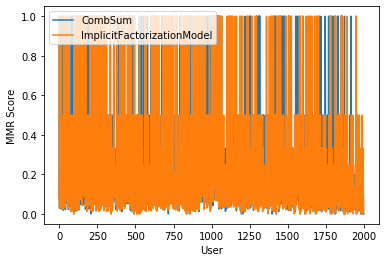

In [0]:
#Plot the before and after RR scores for each user, compared to the best model from Question 3
import matplotlib.pyplot as plt
# from google.colab import files

scoreQ2 = mrr_score(best_model_Q2, test_dataset, k=100)
combSumScore = mrr_score(CombSum(), test_dataset, k=100)

plt.plot(combSumScore, label='CombSum')
plt.plot(scoreQ2, label='ImplicitFactorizationModel')
plt.ylabel('MMR Score')
plt.xlabel('User')
plt.legend(loc="upper left")
# plt.savefig("mmr.png")
# files.download("mmr.png")
plt.show()


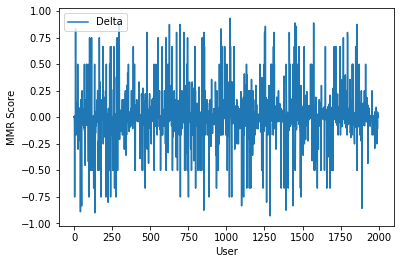

In [0]:
#Plot the deltas
plt.plot(combSumScore - scoreQ2, label='Delta')
plt.ylabel('MMR Score')
plt.xlabel('User')
plt.legend(loc="upper left")
plt.show()


In [0]:
print('Number of users improved ' + str(np.sum(combSumScore > scoreQ2)))

Number of users improved 899


#Q5

In [0]:
#calculate lift
#solution taken from lab 1

positives=ratings_df[ratings_df["rating"]>=4].drop(["Unnamed: 0"], axis=1)

#join positives with itself on userId to get all pairs of books rated by a given user.
pairs=pd.merge(positives, positives, on=["user_id"])

sequences=pairs[pairs["book_id_x"] < pairs["book_id_y"]] 


#count the frequency of each pair of books.
paircounts=sequences[["book_id_x", "book_id_y", "user_id"]].groupby(["book_id_x", "book_id_y"]).count()

#sort by the most popular pairs.
pairswithcounts = paircounts.reset_index().rename(columns={"user_id" : "rating_counts"}).sort_values(['rating_counts'], ascending=False)

#display the top most frequent pairs

#lift of all pairs
bookCounts = positives.groupby(["book_id"]).count()[["user_id"]].reset_index().rename(columns={"user_id" : "ratingCount"})

#puts all the information in the sample dataframe.
allstats = pairswithcounts.merge(bookCounts, left_on="book_id_x", right_on="book_id").merge(bookCounts, left_on="book_id_y", right_on="book_id")

# drop out some unused columns
allstats = allstats[["book_id_x",	"book_id_y",	"rating_counts", "ratingCount_x", "ratingCount_y"]]
allstats = allstats.loc[:,~allstats.columns.duplicated()]

#calculate probabilites we need a denominator
num=float(ratings_df.count()["rating"])

# perform artihmetic on columns
allstats["lift"] = (allstats["rating_counts"] / num ) / ( (allstats["ratingCount_x"] / num) * (allstats["ratingCount_y"] / num))
allstats.head()


,book_id_x,book_id_y,rating_counts,ratingCount_x,ratingCount_y,lift
0,1,17,277,502,365,188.610348
1,2,17,84,399,365,71.960779
2,4,17,93,528,365,60.205822
3,5,17,76,395,365,65.766686
4,16,17,108,306,365,120.640129


In [0]:
#recommender where the score for each target recommended item is
#the sum of the log (lift) between positively rated items in the user profile (rating ≥ 4) and the target item
import math

class liftBased_Recommender :
  
  def __init__(self, ratedBookslst, allstatsMap):
      self.ratedBookslst = ratedBookslst
      self.allstatsMap = allstatsMap

  def predict(self, uid) :
    #get all the books which are rated by the user and convert to a list
    userRated = ratings_df[ratings_df["user_id"] == uid_rev_map[uid]]
    userRatedlst = userRated["book_id"].to_list()
    #get all the positively rated books which are rated by the user and convert to a list
    positives = userRated[userRated.rating >= 4]
    positiveBooks = positives["book_id"].to_list()
    result = []
    
    #loop through all rated books
    #if book not found in user rated list 
      #loop on the positiveBooks and calculate the log(lift) of all the pairs using the dictionary allstatsMap
    for curr_id in self.ratedBookslst :
      sumLogLift = 0
      if curr_id not in userRatedlst :
        for j in positiveBooks :
          key = (min(curr_id, j), max(curr_id, j))
          if key in self.allstatsMap:
            logLift = math.log(self.allstatsMap[key])
            sumLogLift += logLift
        result.append(sumLogLift)
      else :
        result.append(0)
        
    return np.array(result)

#convert the allstats df to a dictionary to minimize the use of df in the loop
allstatsMap = allstats[['book_id_x', 'book_id_y', 'lift']].set_index(['book_id_x', 'book_id_y'])["lift"].to_dict()
#get all rated books and convert to a list
ratedBooks = ratings_df.groupby(["book_id"], sort=False).mean().reset_index()
ratedBookslst = ratedBooks["book_id"].to_list()
#print the mmr score
print(mrr_score(liftBased_Recommender(ratedBookslst, allstatsMap), test_dataset, train=rating_dataset, k=100).mean())

0.3631263802992653


In [0]:
allstats

,book_id_x,book_id_y,rating_counts,ratingCount_x,ratingCount_y,lift
0,1,17,277,502,365,188.610348
1,2,17,84,399,365,71.960779
2,4,17,93,528,365,60.205822
3,5,17,76,395,365,65.766686
4,16,17,108,306,365,120.640129
...,...,...,...,...,...,...
538502,371,1840,1,42,1,2970.523810
538503,841,1840,1,10,1,12476.200000
538504,980,1840,1,9,1,13862.444444
538505,433,1840,1,7,1,17823.142857


In [0]:
#find minimum Support Count threshold 
thresholds = [2,3,10,20,40]
best_score = 0
minumum_count = 0
best_pair = 0
threshold_score = {}
ratedBooks = ratings_df.groupby(["book_id"], sort=False).mean().reset_index()
ratedBookslst = ratedBooks["book_id"].to_list()

#loop through the thresholds
#filter the allstats df to get all the pairs having rating_counts more than the threshold
#find the best score and the minumum count support 
for i in thresholds : 
  allstatsRating = allstats[allstats.rating_counts >= i]
  allstatsMap = allstatsRating[['book_id_x', 'book_id_y', 'lift']].set_index(['book_id_x', 'book_id_y'])["lift"].to_dict()
  # print(len(allstatsMap))
  score = mrr_score(liftBased_Recommender(ratedBookslst, allstatsMap), validation, train=rating_dataset, k=100).mean()
  threshold_score[i] = score
  if(score >= best_score) :
    best_score = score
    minumum_count = i
    best_pair = allstatsMap

print('minumum_count ', minumum_count)
print('best_score ', score)
#print the mrr score on the pair obtained on the test set
print(mrr_score(liftBased_Recommender(ratedBookslst, best_pair), test_dataset, train=rating_dataset, k=100).mean())

minumum_count  2
best_score  0.012527199014575049
0.4015039235776294


In [0]:
threshold_score

{2: 0.01677277878252574,
 3: 0.014992784188318186,
 10: 0.01560800266248275,
 20: 0.013609901531196338,
 40: 0.012527199014575049}

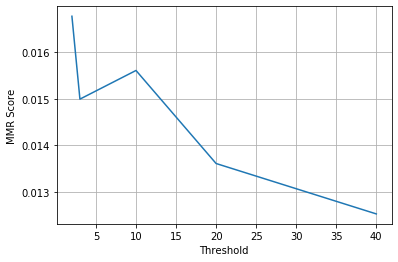

In [0]:
#plot how MRR responds to adjustments in the minimum Support Count threshold
# from google.colab import files
plt.plot(list(threshold_score.keys()),list(threshold_score.values()))
plt.ylabel('MMR Score')
plt.xlabel('Threshold')
plt.grid(True)
# plt.savefig("mmr.png")
# files.download("mmr.png")
plt.show()

#Q6

In [0]:
#combine the outputs of Questions 1, 2, 3 & 5 using a weighted CombSum score 
class CombSumCombination :
  def predict(self, uid) :
    weight = [0.9, 1, 0.5]
    #use best_pair obtained from the minimum Support threshold
    q5Model = liftBased_Recommender(ratedBookslst, best_pair)

    #normalize the models
    q2_norm = preprocessing.normalize([best_model_Q2.predict(uid)]).flatten()
    q3_norm = preprocessing.normalize([best_model_Q3.predict(uid)]).flatten()
    q5_norm = preprocessing.normalize([q5Model.predict(uid)]).flatten()

    #multiply by the weight
    q2BestRank = np.multiply(q2_norm,weight[0])
    q3BestRank = np.multiply(q3_norm,weight[1])
    q5BestRank = np.multiply(q5_norm,weight[2])

    return np.add(q2BestRank, q3BestRank, q5BestRank)

#print the mmr score
print(mrr_score(CombSumCombination(), test_dataset, train=rating_dataset, k=100).mean())

0.41590256200060455


In [0]:
#combine the outputs of Questions 2, 3 & 5 using a different combination of weight 
class CombSumCombination :
  def predict(self, uid) :
    weight = [1, 0.7, 0.7]
    #use best_pair obtained from the minimum Support threshold
    q5Model = liftBased_Recommender(ratedBookslst, best_pair)

    #normalize the models
    q2_norm = preprocessing.normalize([best_model_Q2.predict(uid)]).flatten()
    q3_norm = preprocessing.normalize([best_model_Q3.predict(uid)]).flatten()
    q5_norm = preprocessing.normalize([q5Model.predict(uid)]).flatten()

    #multiply by the weight
    q2BestRank = np.multiply(q2_norm,weight[0])
    q3BestRank = np.multiply(q3_norm,weight[1])
    q5BestRank = np.multiply(q5_norm,weight[2])

    return np.add(q2BestRank, q3BestRank, q5BestRank)

#print the mmr score
print(mrr_score(CombSumCombination(), test_dataset, train=rating_dataset, k=100).mean())

0.419619502209745
